In [1]:
!pip install summa

In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


#### Step 1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
18054,"1 killed, 4 injured in shooting at McDonald's ...",At least one person was killed and four others...
87014,"Will clear Ã¢ÂÂ¹25,000 crore debt by Sept 30:...",Anil Ambani-led Reliance Communications said i...
96619,World's first film studio was built in Thomas ...,"'Black Maria', which was built in 1893 on the ..."
57812,1 in 7 traffic cops suffers from breathing pro...,At least one in every seven traffic policemen ...
83644,Glad people remember Komolika even after 16 ye...,Television actress Urvashi Dholakia has said s...
13108,Gazing endangered monkeys picture wins 2018's ...,A picture of two golden snub-nosed endangered ...
79459,Qatar changes anti-terror law amid Arab boycott,Qatar on Thursday announced changes to its ant...
11949,"Over 2,200 cars found registered in name of ex...","Over 2,200 cars have been found registered in ..."
76490,No failure on part of police: Chandigarh stalk...,"""I haven't seen any failure on the part of pol..."
50824,India beat hosts NZ in second leg of Four Nati...,The Indian men's hockey team defeated hosts Ne...


#### Step 2. 데이터 전처리하기
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용
- 텍스트를 정규화 또는 정제
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민

In [5]:
len(data)

98401

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

def remove_unuseful_words(sentence, contractions, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def preprocess(data, main_column_name, summary_column_name, contractions):
  processed = data.copy()
  # 중복 제거
  processed.drop_duplicates(subset = [main_column_name], inplace=True)
  # nan 제거
  processed.dropna(axis=0, inplace=True)

  # 불용어 제거
  clean_text = []
  for text in processed[main_column_name]:
    clean_text.append(remove_unuseful_words(text, contractions))
  processed[main_column_name] = clean_text

  # 불용어 미제거
  clean_summary = []
  for summary in processed[summary_column_name]:
    clean_summary.append(remove_unuseful_words(summary, contractions, False))
  processed[summary_column_name] = clean_summary

  # 한 번 더 nan 제거
  processed.dropna(axis=0, inplace=True)

  return processed

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

preprocessed_data = preprocess(data, 'text', 'headlines', contractions)
print('전체 샘플수 (전처리 전) :', (len(data)))
print('전체 샘플수 (전처리 후) :', (len(preprocessed_data)))

전체 샘플수 (전처리 전) : 98401
전체 샘플수 (전처리 후) : 98360


In [10]:
preprocessed_data.isnull().sum()

headlines    0
text         0
dtype: int64

In [11]:
preprocessed_data['text'][95055]

'congress said total crore farmer loans crore waived means even crore still waived said congress spokesperson randeep surjewala modi government could waive crore loan big businessmen cannot farmers added'

시퀀스의 최대 크기 정하기

In [12]:
def get_text_len(rows):
  rows_len = [len(s.split()) for s in rows]
  print('최소 길이 : {}'.format(np.min(rows_len)))
  print('최대 길이 : {}'.format(np.max(rows_len)))
  print('평균 길이 : {}'.format(np.mean(rows_len)))
  return rows_len

In [13]:
text_len = get_text_len(preprocessed_data['text'])
summary_len = get_text_len(preprocessed_data['headlines'])

최소 길이 : 1
최대 길이 : 60
평균 길이 : 35.09968483123221
최소 길이 : 1
최대 길이 : 16
평균 길이 : 9.299532330215534


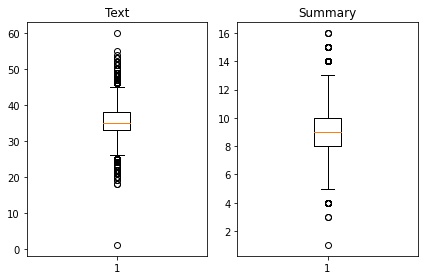

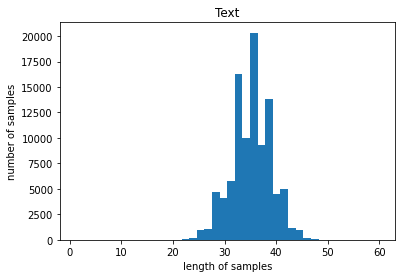

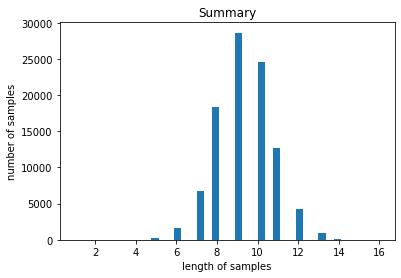

In [14]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
def get_max_len(rows, percent):
  rows_len = [len(s.split()) for s in rows]
  max_len = int(np.percentile(rows_len, percent))
  return max_len

In [16]:
text_max_len = get_max_len(preprocessed_data['text'], 80)
summary_max_len = get_max_len(preprocessed_data['headlines'], 95)
text_max_len, summary_max_len

(38, 12)

**흠.. 궁금? 데이터 갯수가 중요할까 패딩이 얼만큼 많은지가 더 중요할까?**

In [17]:
def remove_long_sequence(rows, max_len):
  return rows.apply(lambda x: len(x.split()) <= max_len)

In [18]:
preprocessed_data = preprocessed_data[
    remove_long_sequence(preprocessed_data['text'], text_max_len) &
    remove_long_sequence(preprocessed_data['headlines'], summary_max_len)
  ]

len(preprocessed_data)

79296

In [19]:
preprocessed_data.head()

,headlines,text
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...


In [20]:
preprocessed_data['decoder_input'] = preprocessed_data['headlines'].apply(lambda x : 'sostoken '+ x)
preprocessed_data['decoder_target'] = preprocessed_data['headlines'].apply(lambda x : x + ' eostoken')
preprocessed_data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
encoder_input = np.array(preprocessed_data['text']) # 인코더의 입력
decoder_input = np.array(preprocessed_data['decoder_input']) # 디코더의 입력
decoder_target = np.array(preprocessed_data['decoder_target']) # 디코더의 레이블

훈련 데이터랑 테스트 데이터 분리

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [23]:
print(indices)

[46602 76786 65697 ... 43183 68938 40761]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15859


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 63437
훈련 레이블의 개수 : 63437
테스트 데이터의 개수 : 15859
테스트 레이블의 개수 : 15859


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61048
등장 빈도가 6번 이하인 희귀 단어의 수: 41573
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19475
단어 집합에서 희귀 단어의 비율: 68.09887301795308
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9461763215460834


In [29]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2587, 1207, 82, 464, 824, 260, 527, 74, 335, 185, 242, 4, 4846, 265, 1, 2587, 210, 3746, 81, 1764, 1255, 2478, 383, 512, 279, 22, 379, 849, 293, 642], [25, 95, 17, 58, 1814, 1086, 1518, 494, 6293, 1, 1061, 247, 6602, 1146, 3, 453, 737, 1086, 2770, 2, 1086, 1390, 734, 439, 21, 1086, 1518, 1052, 243, 849, 1164, 8], [442, 1, 3548, 6041, 1166, 169, 358, 3803, 1519, 1366, 167, 2, 6205, 7022, 532, 413, 1519, 1366, 435, 1, 7255, 613, 472, 1519, 3639, 1366, 435]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27437
등장 빈도가 5번 이하인 희귀 단어의 수: 18210
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9227
단어 집합에서 희귀 단어의 비율: 66.37022998141197
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.34980372628039


In [33]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 13, 794, 1104, 1124], [1, 720, 1920, 3, 26, 107], [1, 1921, 7, 211, 91, 210], [1, 870, 20, 1949, 13, 3, 786, 5], [1, 34, 6, 1552, 169, 400, 286]]
target
decoder  [[3, 13, 794, 1104, 1124, 2], [720, 1920, 3, 26, 107, 2], [1921, 7, 211, 91, 210, 2], [870, 20, 1949, 13, 3, 786, 5, 2], [34, 6, 1552, 169, 400, 286, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

삭제할 훈련 데이터의 개수 : 8
삭제할 테스트 데이터의 개수 : 2


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

#### Step 3. 어텐션 메커니즘 사용하기
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있음
- 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
248/248 [==============================] - 130s 485ms/step - loss: 3.9557 - val_loss: 3.6612
Epoch 2/50
248/248 [==============================] - 119s 480ms/step - loss: 3.5274 - val_loss: 3.3568
Epoch 3/50
248/248 [==============================] - 119s 481ms/step - loss: 3.2646 - val_loss: 3.1635
Epoch 4/50
248/248 [==============================] - 118s 478ms/step - loss: 3.0801 - val_loss: 3.0243
Epoch 5/50
248/248 [==============================] - 119s 481ms/step - loss: 2.9329 - val_loss: 2.9025
Epoch 6/50
248/248 [==============================] - 119s 479ms/step - loss: 2.8151 - val_loss: 2.8247
Epoch 7/50
248/248 [==============================] - 119s 479ms/step - loss: 2.7182 - val_loss: 2.7578
Epoch 8/50
248/248 [==============================] - 119s 481ms/step - loss: 2.6337 - val_loss: 2.7125
Epoch 9/50
248/248 [==============================] - 118s 477ms/step - loss: 2.5600 - val_loss: 2.6700
Epoch 10/50
248/248 [==============================] - 119s 478m

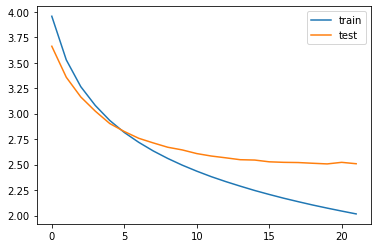

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Step 4. 실제 결과와 요약문 비교하기
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 요약 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [48]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre planning increase jail term existing months months abuse elderly parents centre also planning make amount allowance maintenance welfare parents senior citizens act currently upper limit per month 
실제 요약 : govt month jail for those parents 
예측 요약 :  govt approves crore for visa


원문 : information broadcasting ministry thursday informed lok sabha government proposed ban advertisements food television however lower house decision nine major food business operators voluntarily high fat sugar salt food products children channels 
실제 요약 : no proposal to ban ads on food on govt 
예측 요약 :  govt asks states to ban on


원문 : ekta kapoor announced production house motion pictures producing film amul founder known india film directed toilet ek prem katha director narayan singh adaptation book dream life 
실제 요약 : kapoor to film on founder 
예측 요약 :  to star in remake of upcoming film


원문 : malaika arora speaking metoo movement said women kind harassment whether physical mental emotional 

#### Step 5. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높음
- 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮음

In [49]:
!pip install summa

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [52]:
print(summarize(text, ratio=0.005))

Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [53]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [54]:
print(summarize(data['text'][0], words=30))

The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [55]:
summa_data = data.copy()

In [56]:
summa_data['summarized'] = summa_data['text'].apply(lambda x : summarize(x, words=30))
summa_data.head()

,headlines,text,summarized
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",The program and upGrad's 360-degree career sup...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


In [57]:
for i in range(0, 50):
    print("원문 :", summa_data['text'][i])
    print("요약 :", summa_data['headlines'][i])
    print("Summa 요약 :", summa_data['summarized'][i])
    
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
요약 : upGrad learner switches to career in ML & Al with 90% salary hike
Summa 요약 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit 

- Abstractive 요약 같은 경우에는 기존 문장에 없던 단어도 생성하여 요약하는 경우가 있는데, Summa 같은 경우는 대부분 앞 문단 안에 있는 문장을 그대로 사용한 부분이 많았음
- Summa는 30개 단어로 제한했는데 종종 요약이 되지 않은 경우가 있었음
- Abstractive 같은 경우도 완전히 잘 요약을 생성한다고는 할 수 없는 거 같음

### 회고

1. 실험을 여러 개 하고 싶었는데 커널이 계속 꺼져서 못 한 게 아쉬웠음, 나중에 시간 날 때 해봐야겠음
   - 텍스트 전처리하는 과정에서 최대 시퀀스 길이가 어떤 영향을 미치는지.. 등
2. 이번 실험은 학습하는데 시간이 꽤 오래 걸렸던 거 같음.
3. NLP는 눈에 보이는 게 별로 없어서 그런지 역시 흥미가 덜 한 듯 ㅠ